# Homework1: StockPricePrediction
The stock we choose is: **01913 PRADA**

### Correlated assets
- Indices
- Industry component stocks
- Stock historical prices

### Procedure
* [Data Analysis](#0)
* [Data PreProcessing](#a)
* [Model Evaluation](#b)
* [Model Selection](#c)
* [Model Tuning](#d)

<a id='0'></a>
## Data Analysis


### Data Importing
#### 1. Indices Codes
As the data set contains 2000+ information. First, we need extract the indices data from the data set.

In [6]:
import requests
import re
import json
# import pandas as pd
import os

# data is catched from eastmoney, contains 200+ indices code
url = 'http://13.push2.eastmoney.com/api/qt/clist/get?cb=jQuery1124029175978392917634_1679021002481&pn=1&pz=300&po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&wbp2u=|0|0|0|web&fid=f3&fs=m:124,m:125,m:305'

response = requests.get(url)

# extract body
content = str(response.content, 'UTF-8')
body = re.findall(r'[(](.*?)\);$', content)[0]

resp = json.loads(body)
data = resp['data']
indexes = data['diff']

codes = []
for i in indexes:
    codes.append(i['f12'])

# output = pd.DataFrame({'code': codes})
# output.to_csv('HKIndices.csv', index=False)

# compare to the data
indiceCode = []
filename_raw = os.listdir('data')
for i in filename_raw:
    matchObj = re.match(r'(.*)\.csv', i)
    if matchObj:
        value = matchObj.group(1)
        if value in codes:
          indiceCode.append(value)

# indices code in data set
indiceCode

['CES100', 'CES120', 'CES280', 'CES300', 'CESA80', 'CESG10', 'HSI', 'VHSI']

From the above output, we can see that only 8 remained indices. 
The codes which begin with `CES` are related to the mainland assets, and we are not interested about them.

So, the remain codes are `HSI` and `VHSI`. 
- `HSI`: stands for Hang Seng Index, which is a stock market index that represents the performance of the Hong Kong stock market
- `VHSI`: (Volatility Index of Hang Seng Index) is an index that measures the expected volatility of the Hang Seng Index (HSI)

#### 2. Industry component stocks
We find some relative stocks about luxury goods.

| code | name |
|---------|---------|
| 00590 | 六福集团  |
| 00887 | 英皇钟表珠宝  |
| 01929 | 周大福  |
| 00116 | 周生生  |
| 03389 | 亨得利  |
| 00280 | 景福集团  |
| 00398 | 东方表行集团 |
| 01856 | 依波路  |

#### 3. Loading data
This section combines the above data into one sheet.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import seaborn as sns

# Error Metrics
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

In [2]:
# weekly returns, using 5 business day period returns.
return_period = 5
# data head
head_name = ['date', 'open', 'high', 'low', 'close', 'volumn', 'amount']

# data Y: PRADA Future Returns
stk_data = pd.read_csv('data/01913.csv', names = head_name)
# Y = stk_data.loc[:, ['date', 'close']]
Y = np.log(stk_data.loc[:, ('close')]).diff(return_period).\
    shift(-return_period)
Y = pd.concat([stk_data['date'], Y], axis='columns')
Y.columns = ['date', 'PRADA_pred']

# data X1, X2: HSI, VHSI, -5 time
idx_data1 = pd.read_csv('data/HSI.csv', names = head_name)
idx_data2 = pd.read_csv('data/VHSI.csv', names = head_name)
X1 = np.log(idx_data1.loc[:, ('close')]).diff(return_period)
X1 = pd.concat([idx_data1['date'], X1], axis='columns')
X1.columns = ['date', 'HSI']
X2 = np.log(idx_data2.loc[:, ('close')]).diff(return_period)
X2 = pd.concat([idx_data2['date'], X2], axis='columns')
X2.columns = ['date', 'VHSI']
# inner join by date
idx_X = pd.merge(X2, X1, on='date', how='left')

# data X3, X4, X5: prada-15, prada-30, para-60 lagged dayReturns
# X3 = np.log(stk_data.loc[:, ('close')]).shift(-return_period)
X4 = np.log(stk_data.loc[:, ('close')]).shift(-return_period*3)
X5 = np.log(stk_data.loc[:, ('close')]).shift(-return_period*6)
X6 = np.log(stk_data.loc[:, ('close')]).shift(-return_period*12)
lagged_X = pd.concat([stk_data['date'], X4, X5, X6], axis='columns')
lagged_X.columns = ['date', 'PRADA-15', 'PRADA-30', 'PRADA-60']

# todo industry component stock
# data X7 ~ X15: relative component stocks
x7_data = pd.read_csv('data/00590.csv', names = head_name)
X7 = np.log(x7_data.loc[:, ['close']]).shift(-return_period)
X7 = pd.concat([x7_data['date'], X7], axis='columns')
X7.columns = ['date', 'LukFook']
x8_data = pd.read_csv('data/00887.csv', names = head_name)
X8 = np.log(x8_data.loc[:, ['close']]).shift(-return_period)
X8 = pd.concat([x8_data['date'], X8], axis='columns')
X8.columns = ['date', 'EmperorWJ']
x9_data = pd.read_csv('data/01929.csv', names = head_name)
X9 = np.log(x9_data.loc[:, ['close']]).shift(-return_period)
X9 = pd.concat([x9_data['date'], X9], axis='columns')
X9.columns = ['date', 'ChowTaiFook']
x10_data = pd.read_csv('data/00116.csv', names = head_name)
X10 = np.log(x10_data.loc[:, ['close']]).shift(-return_period)
X10 = pd.concat([x10_data['date'], X10], axis='columns')
X10.columns = ['date', 'ChowSangSang']
x11_data = pd.read_csv('data/03389.csv', names = head_name)
X11 = np.log(x11_data.loc[:, ['close']]).shift(-return_period)
X11 = pd.concat([x11_data['date'], X11], axis='columns')
X11.columns = ['date', 'Hengdeli']
x12_data = pd.read_csv('data/00280.csv', names = head_name)
X12 = np.log(x12_data.loc[:, ['close']]).shift(-return_period)
X12 = pd.concat([x12_data['date'], X12], axis='columns')
X12.columns = ['date', 'KingFook']
x13_data = pd.read_csv('data/00398.csv', names = head_name)
X13 = np.log(x13_data.loc[:, ['close']]).shift(-return_period)
X13 = pd.concat([x13_data['date'], X13], axis='columns')
X13.columns = ['date', 'OrientalW']
x14_data = pd.read_csv('data/01856.csv', names = head_name)
X14 = np.log(x14_data.loc[:, ['close']]).shift(-return_period)
X14 = pd.concat([x14_data['date'], X14], axis='columns')
X14.columns = ['date', 'ERNESTBOREL']

X = pd.merge(idx_X, lagged_X, on='date', how='left')
X = pd.merge(X, X7, on='date', how='left')
X = pd.merge(X, X8, on='date', how='left')
X = pd.merge(X, X9, on='date', how='left')
X = pd.merge(X, X10, on='date', how='left')
X = pd.merge(X, X11, on='date', how='left')
X = pd.merge(X, X12, on='date', how='left')
X = pd.merge(X, X13, on='date', how='left')
X = pd.merge(X, X14, on='date', how='left')

dataset = pd.merge(Y, X, on='date', how='left')
dataset = dataset.dropna()

Y = dataset.loc[:, ['date', 'PRADA_pred']]
Y['date'] = pd.to_datetime(Y['date'])
Y = Y.set_index('date')
Y = Y.dropna()

X['date'] = pd.to_datetime(X['date'])
X = X.set_index('date')
X = X.dropna()

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

### Data Analysis
#### Descriptive Statistics

In [168]:
dataset.describe()

,PRADA_pred,VHSI,HSI,PRADA-15,PRADA-30,PRADA-60,LukFook,EmperorWJ,ChowTaiFook,ChowSangSang,Hengdeli,KingFook,OrientalW,ERNESTBOREL
count,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,-0.004264,0.002702,0.001804,3.428830,3.419917,3.407441,3.118284,-1.279779,1.976702,2.774561,-0.069947,-0.412457,0.273065,0.561089
std,0.049982,0.133587,0.025191,0.223080,0.216082,0.200979,0.210611,0.275722,0.234711,0.159702,0.407785,0.206587,0.226212,0.209776
min,-0.141015,-0.454371,-0.113870,3.015535,3.032546,3.013081,2.551006,-1.910543,1.446919,2.394252,-0.994252,-0.776529,-0.116534,0.039221
25%,-0.035817,-0.071407,-0.013629,3.267666,3.267666,3.273364,2.954910,-1.435485,1.754404,2.664447,-0.301105,-0.527633,0.076961,0.438255
50%,-0.003578,-0.011101,0.003763,3.351657,3.351657,3.363842,3.113515,-1.220780,2.026832,2.782539,-0.094311,-0.446287,0.307485,0.530628
75%,0.024460,0.054833,0.016757,3.591818,3.565298,3.499533,3.297687,-1.049822,2.158715,2.890372,0.223144,-0.301105,0.494696,0.678034
max,0.216699,0.864305,0.110608,3.948355,3.948355,3.948355,3.572346,-0.744440,2.397895,3.068053,0.698135,0.254642,0.625938,1.178655


In [169]:
dataset.head()

,date,PRADA_pred,VHSI,HSI,PRADA-15,PRADA-30,PRADA-60,LukFook,EmperorWJ,ChowTaiFook,ChowSangSang,Hengdeli,KingFook,OrientalW,ERNESTBOREL
839,2014/11/19,0.042820,-0.055003,-0.023880,3.794365,3.787593,3.750680,3.144152,-1.049822,2.375836,3.005683,0.385262,-0.040822,0.500775,1.178655
840,2014/11/20,0.045950,-0.099178,-0.028303,3.781914,3.772761,3.751854,3.242592,-1.035637,2.379546,3.039749,0.371564,-0.051293,0.494696,1.121678
841,2014/11/21,0.028285,-0.205002,-0.027367,3.787593,3.760037,3.751854,3.238678,-1.035637,2.381396,3.046901,0.405465,-0.051293,0.494696,1.043804
842,2014/11/24,0.007089,-0.090085,0.004029,3.789855,3.740048,3.789855,3.228826,-1.035637,2.388763,3.025291,0.418710,-0.083382,0.494696,1.022451
843,2014/11/25,-0.018127,-0.147677,0.013069,3.793239,3.757706,3.794365,3.228826,-1.021651,2.377693,3.025291,0.405465,-0.105361,0.494696,1.036737


#### Data Visualization

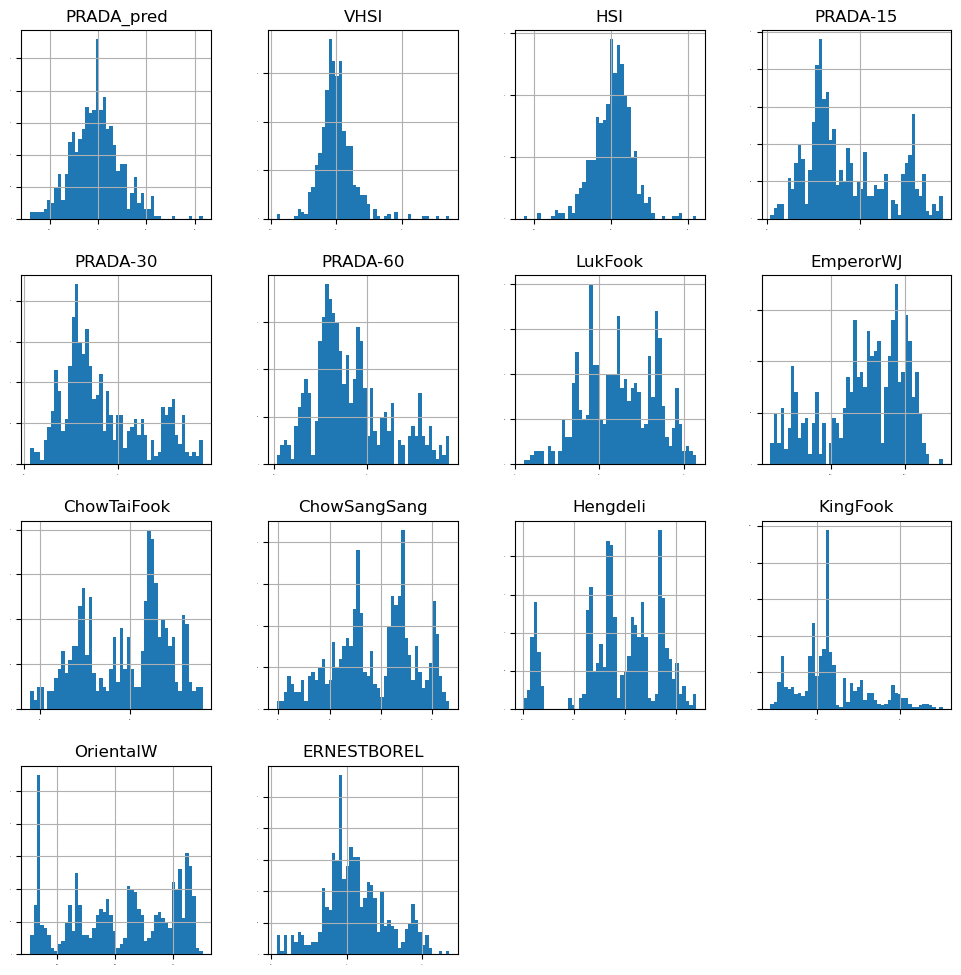

In [170]:
# Make a histogram of the DataFrame’s columns
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each columns. Next we see the density distribution over the same x axis scale.

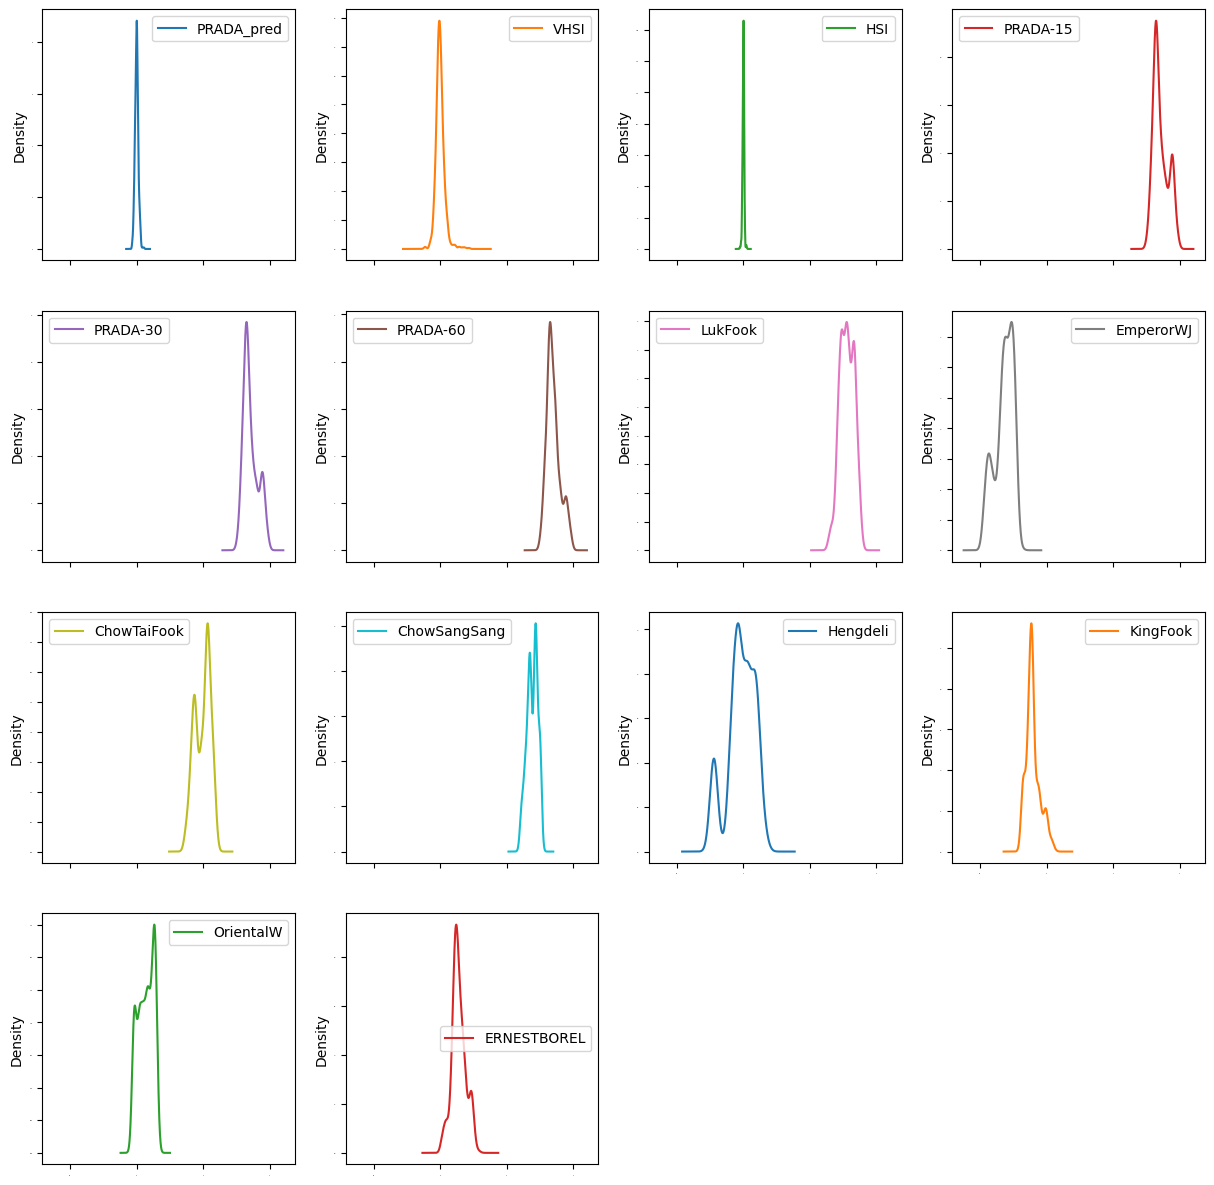

In [171]:
# show the density distribution
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

Then we look at the scatter plot and the correlation matrix to get a sense of the interdependence of the data.

<AxesSubplot:title={'center':'Correlation Matrix'}>

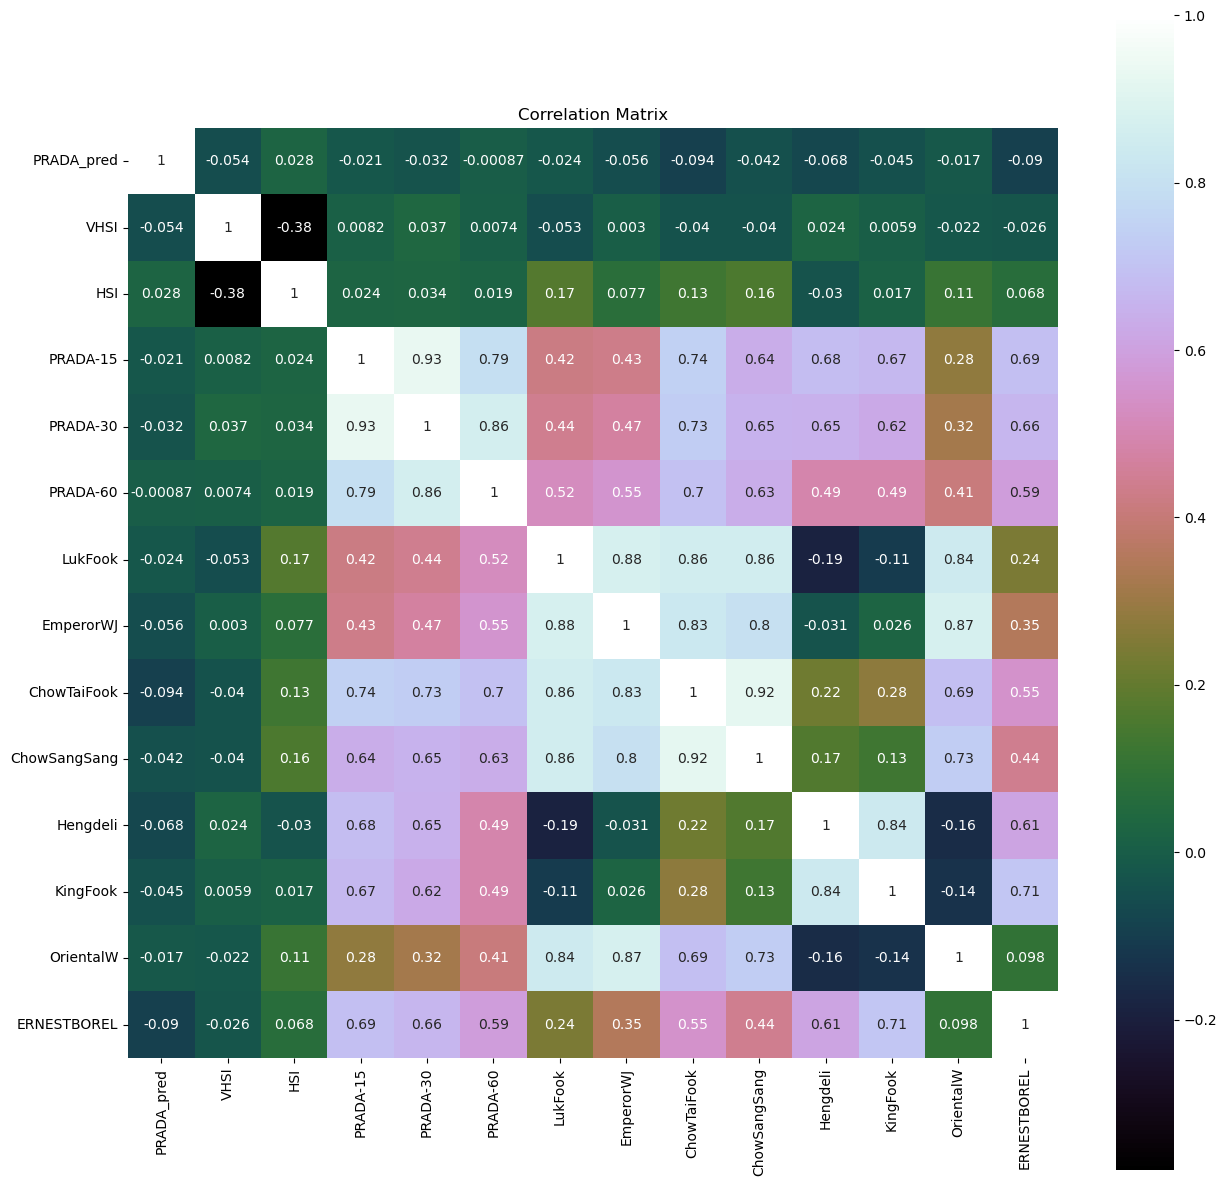

In [172]:
# Compute pairwise correlation of columns, excluding NA/null values
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

We can see that EmperorWJ, ChowTaiFook, ChowSangSang, OrientalW, KingFook have high corelation with other variables(the middle of heatmap), lets delete them and see the result.

<AxesSubplot:title={'center':'Correlation Matrix'}>

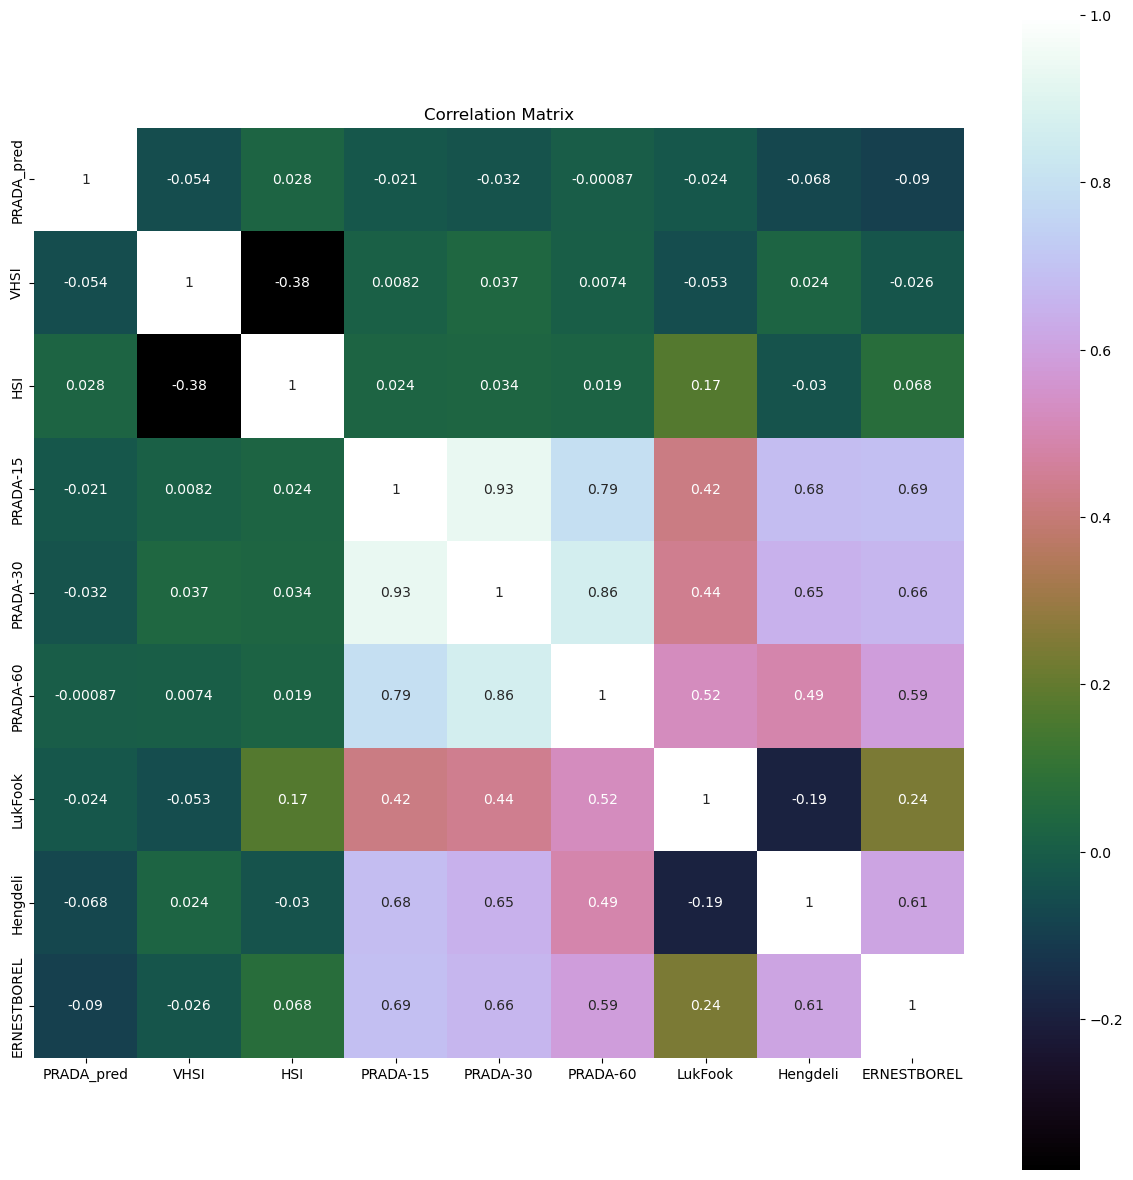

In [4]:
dataset_1 = dataset.drop(columns=['EmperorWJ', 'ChowTaiFook', 'ChowSangSang', 'OrientalW', 'KingFook'])
X = X.drop(columns=['EmperorWJ', 'ChowTaiFook', 'ChowSangSang', 'OrientalW', 'KingFook'])
# show the Correlation Matrix again
# Compute pairwise correlation of columns, excluding NA/null values
correlation = dataset_1.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Next, we can visualize the relationship between all the variables in the regression using the scatterplot matrix.

<Figure size 2000x2000 with 0 Axes>

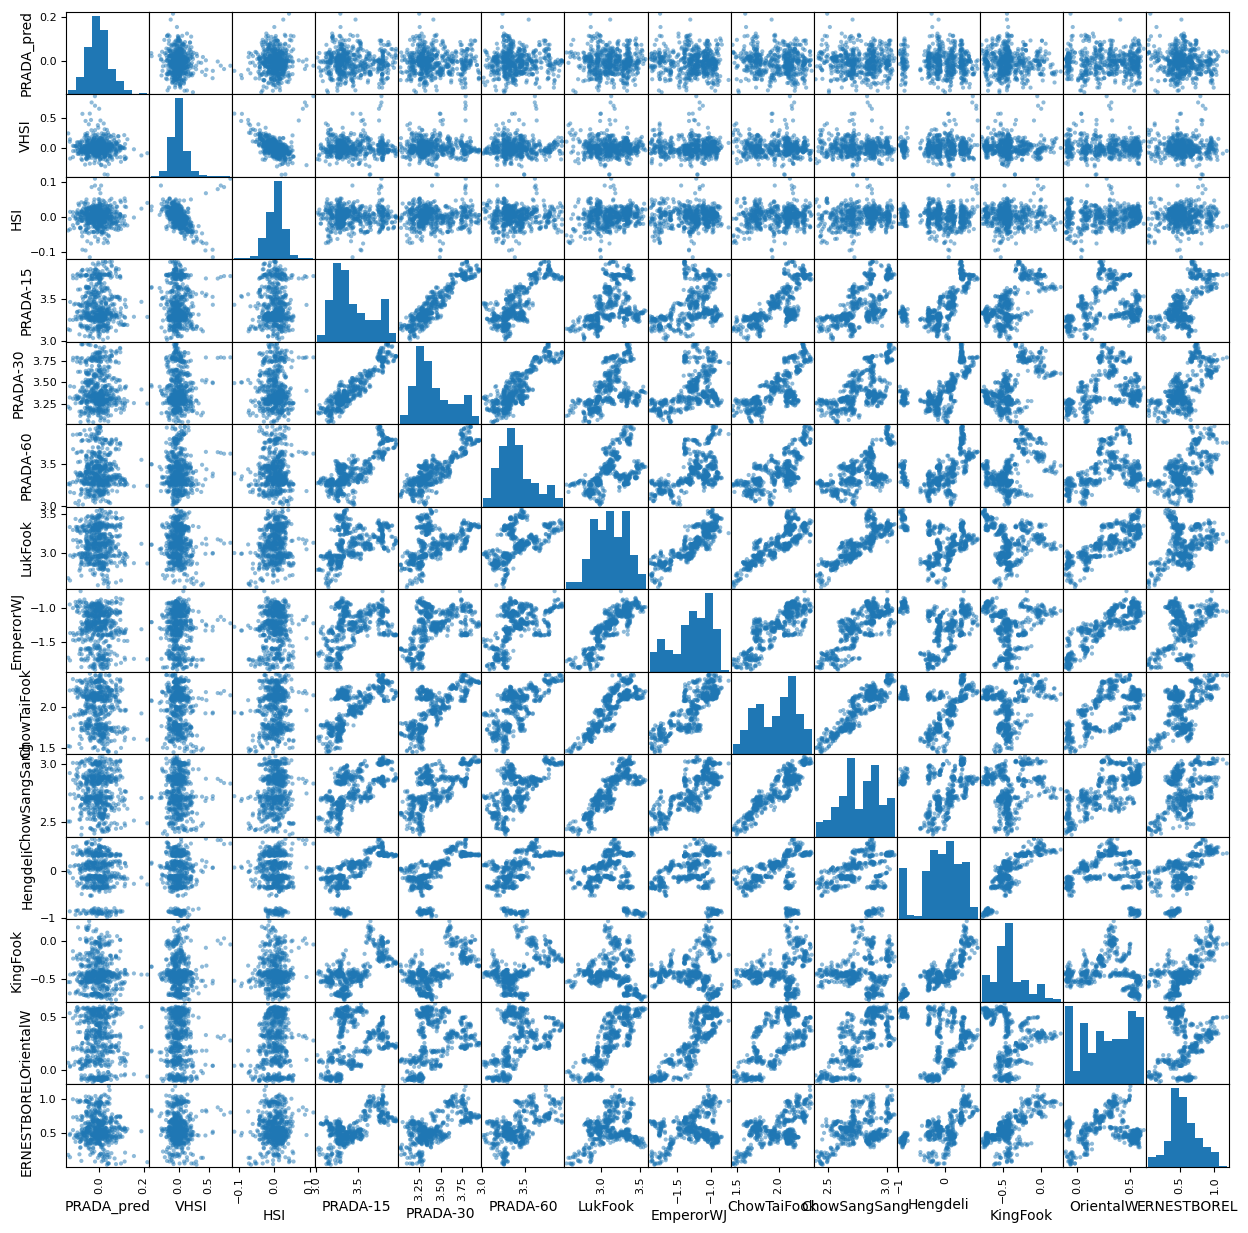

In [174]:
from pandas.plotting import scatter_matrix

pyplot.figure(figsize=(20,20))
scatter_matrix(dataset,figsize=(15,15))
pyplot.show()

From the scatterplot matrix, we can that there are some linear relationship between variables.

Next, we look at the seasonal decomposition of time series.

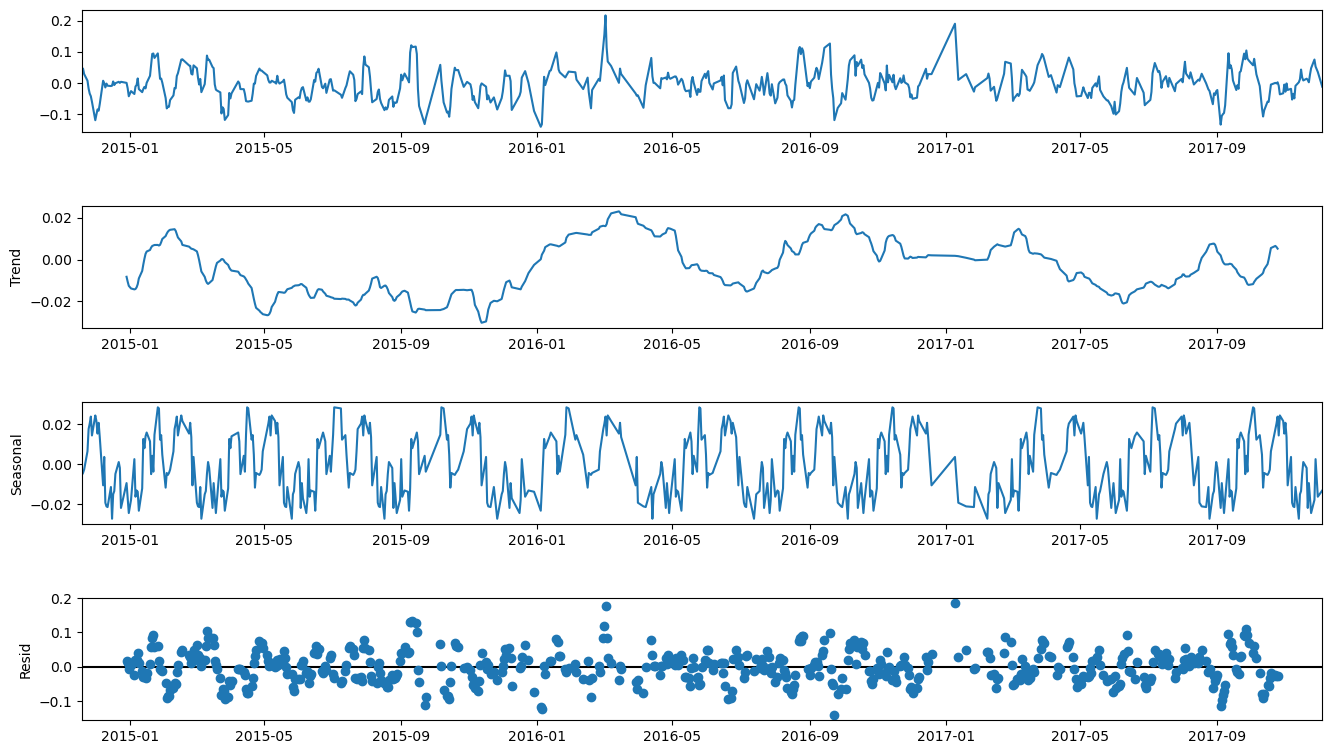

In [175]:
res = sm.tsa.seasonal_decompose(Y, model='additive', period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see the trend of PRADA is fluctuating and has seasonal volatility.

<a id='a'></a>
## Data PreProcessing


### Feature Selection

We use `SelectKBest` to choose the k highest scores, `score_func` is `f_regression`.

In [5]:
# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
ERNESTBOREL,4.885968
Hengdeli,2.802183
VHSI,1.761377
PRADA-30,0.602556
HSI,0.480267
LukFook,0.345677
PRADA-15,0.275344
PRADA-60,0.000459


The score's table shows that `ERNESTBOREL` got the highest score and `PRADA-60` got the lowest score.
We notice that `LukFook` got the lowest score among the component stocks, so we drop this feature.

In [6]:
X = X.drop(columns=['LukFook'])

The remained X we selected are:
- ERNESTBOREL 5 Business Day Returns
- Hengdeli 5 Business Day Returns
<!-- - LukFook 5 Business Day Returns -->
- PRADA 15 Business Day Returns 
- PRADA 30 Business Day Returns
- PRADA 60 Business Day Returns
- HSI 5 Business DayReturns
- VHSI 5 Business DayReturns

Y: PRADA Future Returns(lagged 5 days)

<a id='b'></a>
## Model Evaluation
### Train-test split
As we are going to use time series model, so we need to split data set in continous series.

In [7]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### Test Options and Evaluation Metrics
We will use k-fold cross validation(k=10) and mean squared error metric to evaluate the model.

In [8]:
num_folds = 10
scoring = 'neg_mean_squared_error'

<a id='c'></a>
## Model Selection



### Compare models

In [60]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))

names = []
kfold_results = []
test_results = []
train_results = []
test_predicts = []
train_predicts = []
for name, model in models:
    names.append(name)

    ## K Fold analysis:
    kfold = KFold(n_splits=num_folds)
    # converted mean square error to positive. The lower the beter
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    t_predicted = res.predict(X_train)
    train_predicts.append(t_predicted)
    train_result = mean_squared_error(t_predicted, Y_train)
    train_results.append(train_result)

    # Test results
    predicted = res.predict(X_test)
    test_predicts.append(predicted)
    test_result = mean_squared_error(predicted, Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.002899 (0.001241) 0.002414 0.004208
LASSO: 0.002595 (0.000998) 0.002540 0.002315
EN: 0.002595 (0.000998) 0.002540 0.002315


### K-fold results

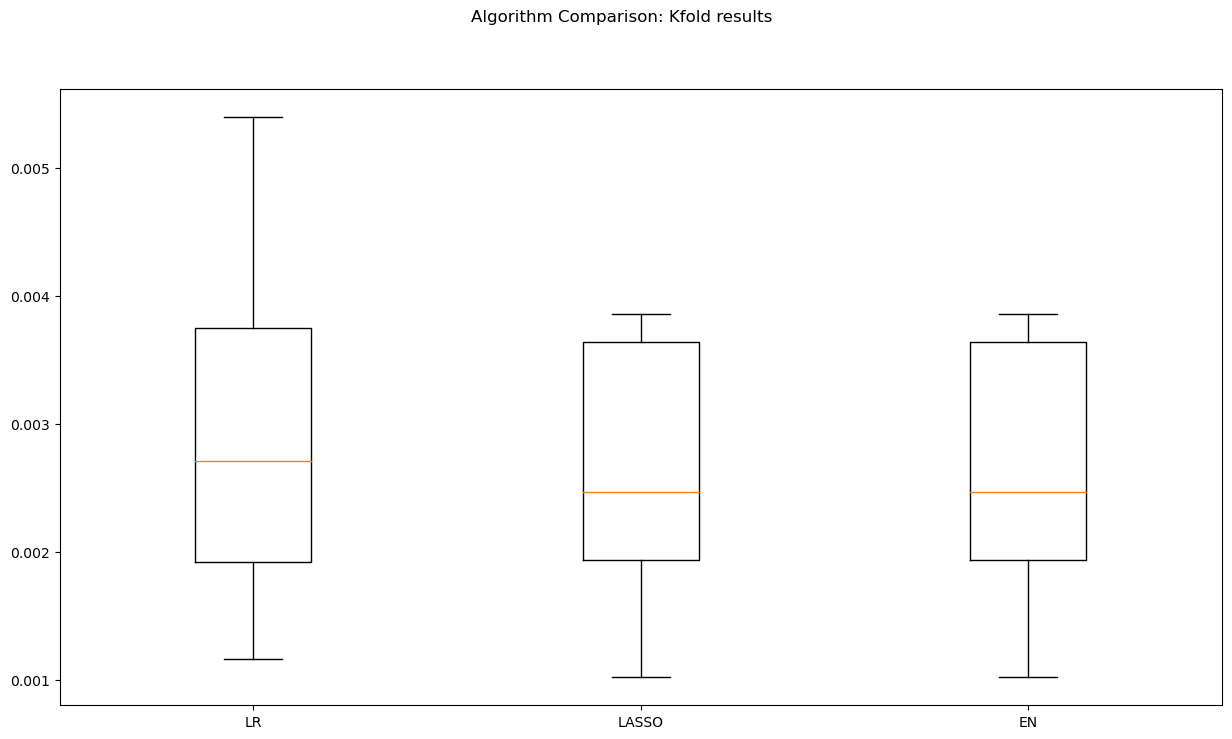

In [10]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We can see that the k-fold result shows that the three linear models' performance are almost the same. But the linear regression(LR) model has higher outliers.

### Training and Test error

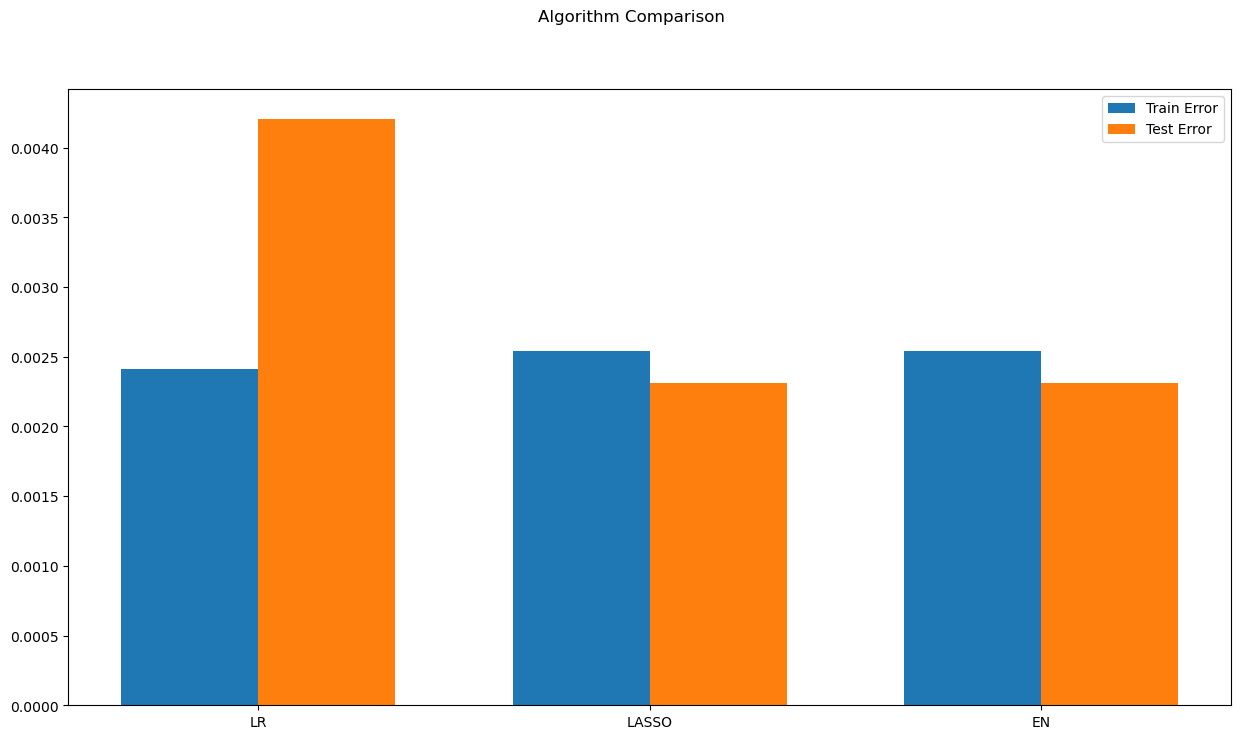

In [11]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

### Time Series based models-ARIMA
Next, we use the model in the example case called ARIMA to fit the dataset. The model we used so far already embed the time series component by using a time-delay approach, where the lagged variable is included as one of the independent variables. However, for the time series-based model ARIMA, we don't need the lagged varaibles of PRADA as the independent variables.

In [12]:
X_train_ARIMA=X_train.loc[:, ['VHSI', 'HSI', 'Hengdeli', 'ERNESTBOREL']]
X_test_ARIMA=X_test.loc[:, ['VHSI', 'HSI', 'Hengdeli', 'ERNESTBOREL']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [185]:
tr_len, te_len, to_len

(484, 121, 605)

In [13]:
# ARIMA model
modelARIMA = sm.tsa.arima.ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1,0,0])
model_fit = modelARIMA.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0026260769177538085

In [14]:
# add ARIMA Training and Test error into result and show it
train_results.append(error_Training_ARIMA)
test_results.append(error_Test_ARIMA)
names.append('ARIMA')

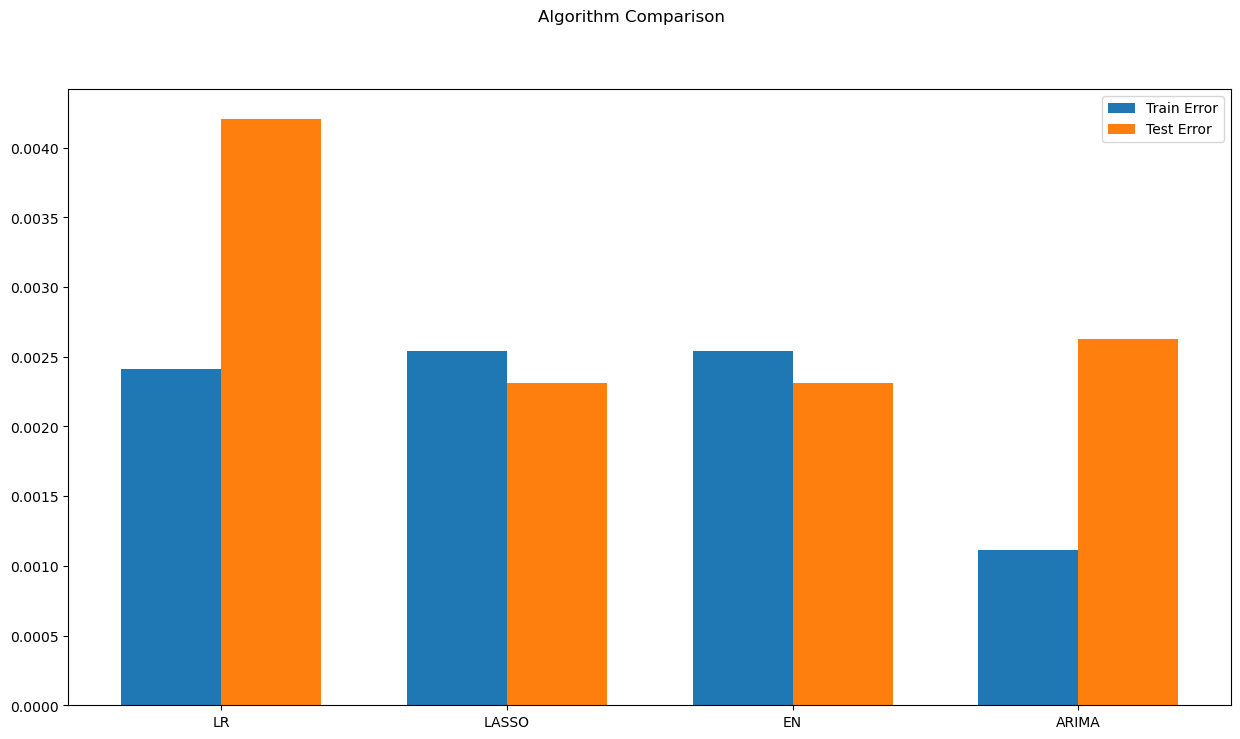

In [15]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

The ARIMA performs best among the above result.

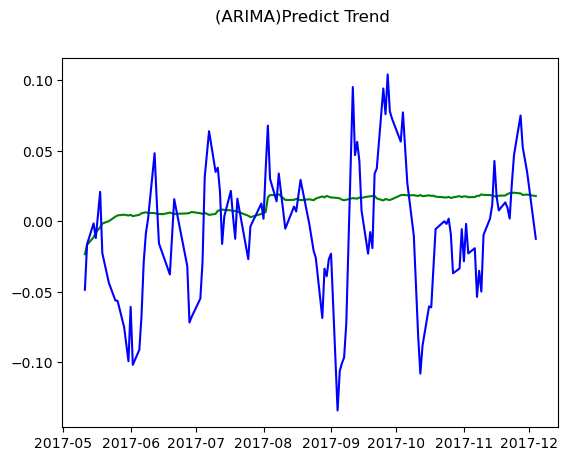

In [41]:
# predict
fig = pyplot.figure()
fig.suptitle('(ARIMA)Predict Trend')
pyplot.plot(Y_test.index, predicted, color='green')
pyplot.plot(Y_test.index, Y_test['PRADA_pred'], color='blue')
# Y_test
pyplot.show()

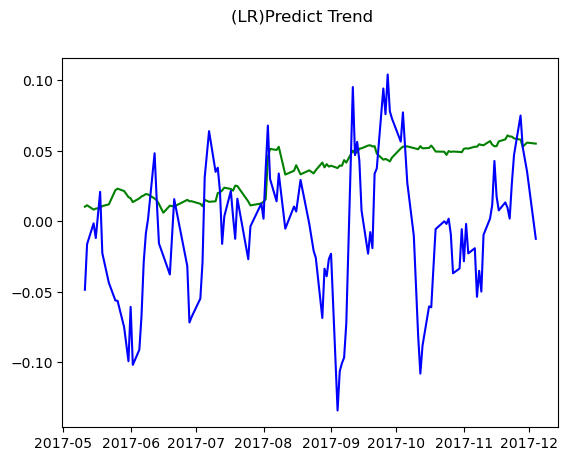

In [43]:
# predict
fig = pyplot.figure()
fig.suptitle('(LR)Predict Trend')
pyplot.plot(Y_test.index, test_predicts[0], color='green')
pyplot.plot(Y_test.index, Y_test['PRADA_pred'], color='blue')
# Y_test
pyplot.show()

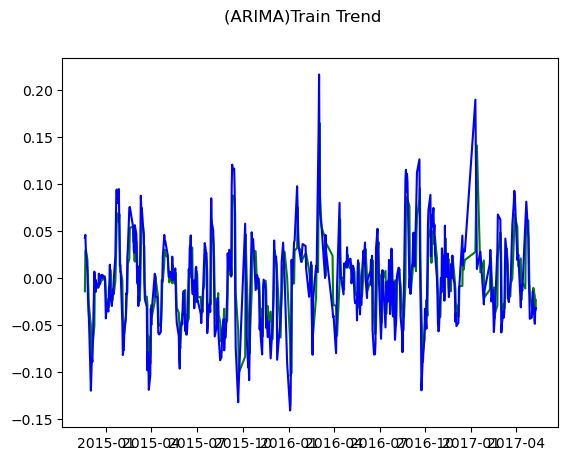

In [54]:
# Y_train, model_fit.fittedvalues
fig = pyplot.figure()
fig.suptitle('(ARIMA)Train Trend')
# predict
pyplot.plot(Y_train.index, model_fit.fittedvalues, color='green')
pyplot.plot(Y_train.index, Y_train['PRADA_pred'], color='blue')
# Y_test
pyplot.show()

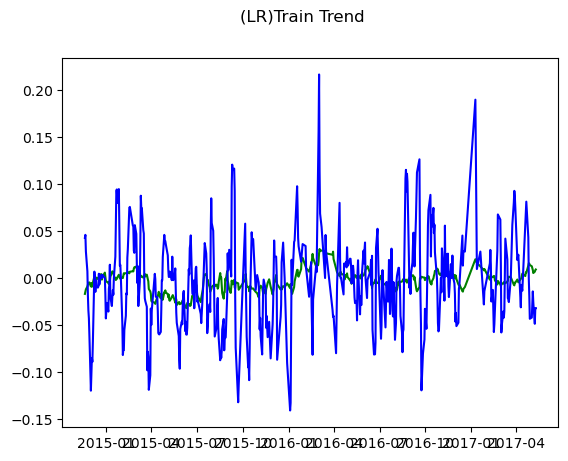

In [61]:
# Y_train, model_fit.fittedvalues
fig = pyplot.figure()
fig.suptitle('(LR)Train Trend')
# predict
pyplot.plot(Y_train.index, train_predicts[0], color='green')
pyplot.plot(Y_train.index, Y_train['PRADA_pred'], color='blue')
# Y_test
pyplot.show()

<a id='d'></a>
## Model Tuning